<a href="https://colab.research.google.com/github/canslove/code-test/blob/master/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reference : [Kaggle](https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now/data)

In [0]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Uploading files from your local file system
files.upload returns a dictionary of the files which were uploaded. The dictionary is keyed by the file name, the value is the data which was uploaded.

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving creditcard.csv to creditcard.csv
User uploaded file "creditcard.csv" with length 150828752 bytes


In [5]:
!pwd

/content


In [43]:
data = pd.read_csv("creditcard.csv")
print(data.shape)
data.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [18]:
data.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

Text(0, 0.5, 'Frequency')

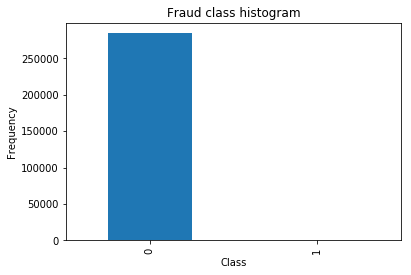

In [19]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

###1. Normalising the amount column. The amount column is not in line with the anonimised features.

In [0]:
from sklearn.preprocessing import StandardScaler

#ss = StandardScaler()
data['normAmount'] = StandardScaler().fit_transform(np.array(data['Amount']).reshape(-1,1))

In [45]:
data.normAmount.describe()

count    2.848070e+05
mean     3.202236e-16
std      1.000002e+00
min     -3.532294e-01
25%     -3.308401e-01
50%     -2.652715e-01
75%     -4.471707e-02
max      1.023622e+02
Name: normAmount, dtype: float64

In [46]:
data = data.drop(['Time','Amount'], axis=1)
print(data.shape)
data.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### 2. Resampling
- Undersampling

In [47]:
data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'normAmount'],
      dtype='object')

In [0]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [50]:
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


In [53]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 41)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

import warnings
warnings.filterwarnings("ignore")

In [0]:
def printing_Kfold_scores(x_train_data,y_train_data):
    cv = KFold(n_splits=5, random_state=42, shuffle=False)

    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')
        
        # Call the logistic regression model with a certain C parameter
        lr = LogisticRegression(C = c_param, penalty = 'l1')

        recall_accs = []
        k=0
        for train_index, test_index in cv.split(x_train_data):
            #print("Train Index: ", train_index, "\n")
            #print("Test Index: ", test_index)

            X_train, X_test, y_train, y_test = x_train_data.iloc[train_index], x_train_data.iloc[test_index], y_train_data.iloc[train_index], y_train_data.iloc[test_index]

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(X_train, y_train)

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(X_test)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_test,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', k+1,': recall score = ', recall_acc)
            k += 1

        # The mean value of those recall scores is the metric we want to save and get hold of.
        #results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        #results_table.set_value(j, 'Mean recall score', np.mean(recall_accs))
        results_table.at[j, 'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('{} th Mean recall score {}'.format(j,np.mean(recall_accs)))
        print('')
    
    print(results_table)
    #best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    max_val = results_table['Mean recall score'].max()
    best_c = results_table[results_table['Mean recall score']==max_val].C_parameter.values
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c[0])
    print('*********************************************************************************')
    
    #return results_table
    return best_c[0]

In [130]:
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.9452054794520548
Iteration  2 : recall score =  0.9178082191780822
Iteration  3 : recall score =  1.0
Iteration  4 : recall score =  0.972972972972973
Iteration  5 : recall score =  0.9545454545454546

1 th Mean recall score 0.9581064252297129

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.8493150684931506
Iteration  2 : recall score =  0.863013698630137
Iteration  3 : recall score =  0.9152542372881356
Iteration  4 : recall score =  0.9459459459459459
Iteration  5 : recall score =  0.8939393939393939

2 th Mean recall score 0.8934936688593526

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.8493150684931506
Iteration  2 : recall score =  0.8767123287671232
Iteration

#### Confusion Matrix

In [0]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.9387755102040817


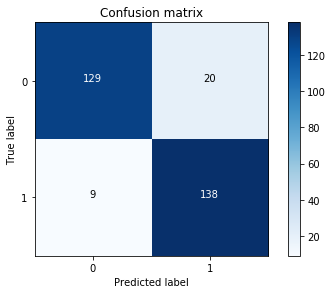

In [132]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Recall metric in the testing dataset:  0.9236111111111112


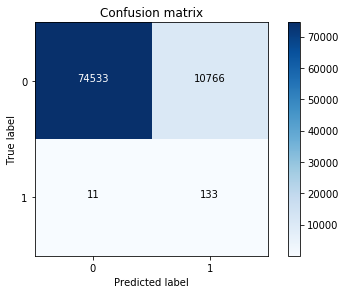

In [133]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### Plotting ROC curve and Precision-Recall curve.

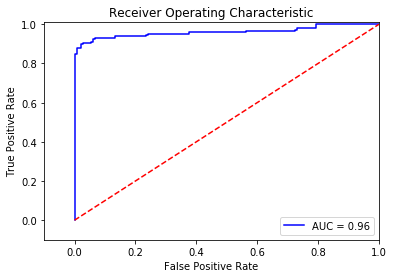

In [134]:
# ROC CURVE
lr = LogisticRegression(C = best_c, penalty = 'l1')
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### changing classification threshold
-  (best C_param = 0.01)

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9659863945578231
Recall metric in the testing dataset:  0.9387755102040817
Recall metric in the testing dataset:  0.8843537414965986
Recall metric in the testing dataset:  0.8163265306122449
Recall metric in the testing dataset:  0.7619047619047619
Recall metric in the testing dataset:  0.5986394557823129


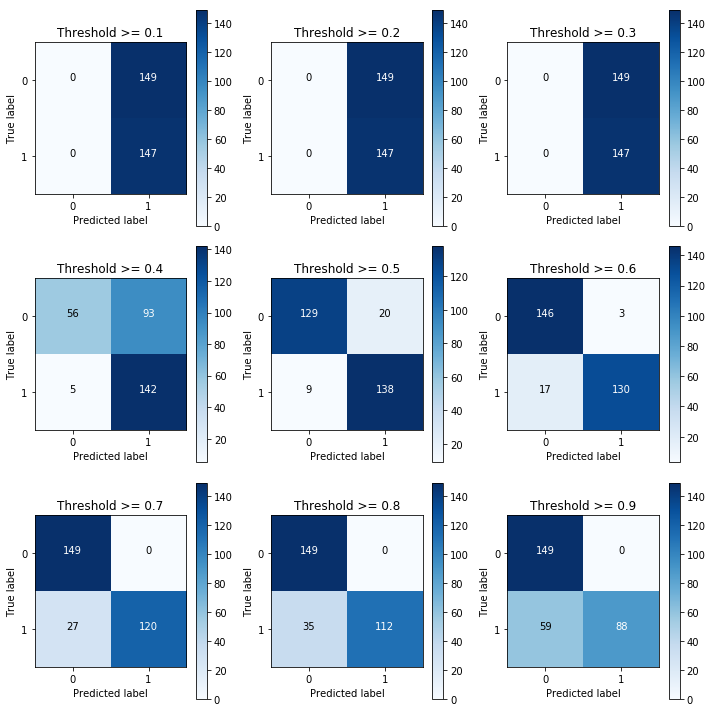

In [135]:
lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test_undersample,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i) 

### Investigate Precision-Recall curve and area under this curve


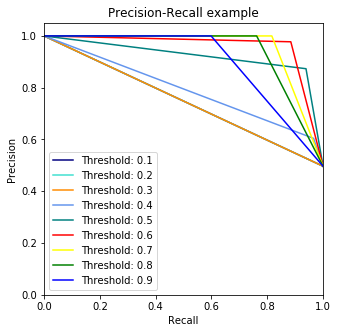

In [136]:
from itertools import cycle

lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(5,5))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_undersample_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test_undersample,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")

##Downloading files from your local file system
files.upload returns a dictionary of the files which were uploaded. The dictionary is keyed by the file name, the value is the data which was uploaded.